<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

`Initial Inspection`

In [50]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# Importing datasets 
features = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/Features data set.csv")
sales = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/sales data-set.csv")
stores = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/stores data-set.csv")

In [16]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Cleaning`

In [17]:
# Dropping unnecessary columns
sales.drop(columns=['Dept'], inplace=True)

In [18]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [19]:
features['Week'] = features.Date.dt.week

C:\Users\fredr\AppData\Local\Temp\ipykernel_15848\2978714185.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  features['Week'] = features.Date.dt.week


In [20]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('Week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
features.drop('Week', axis=1, inplace=True)
features.head()


      Store       Date  Temperature  Fuel_Price     MarkDown1    MarkDown2  \
0         1 2010-02-05        42.31       2.572  24089.612333  1943.950444   
1         1 2010-02-12        38.51       2.548  29880.900556  2524.795909   
2         1 2010-02-19        39.93       2.514  12536.748111  5631.042778   
3         1 2010-02-26        46.63       2.561   8504.312444  4519.585444   
4         1 2010-03-05        46.50       2.625  11293.039000  1050.266627   
...     ...        ...          ...         ...           ...          ...   
8185     45 2013-06-28        76.05       3.639   4842.290000   975.030000   
8186     45 2013-07-05        77.50       3.614   9090.480000  2268.580000   
8187     45 2013-07-12        79.37       3.614   3789.940000  1827.310000   
8188     45 2013-07-19        82.84       3.737   2961.490000  1047.070000   
8189     45 2013-07-26        76.06       3.804    212.020000   851.730000   

       MarkDown3     MarkDown4    MarkDown5         CPI  Unempl

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,False


In [22]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [23]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')
df.head()

,Store,Type,Size,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,0,151315,2010-02-05,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106
1,1,0,151315,2010-02-12,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106
2,1,0,151315,2010-02-19,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106
3,1,0,151315,2010-02-26,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106
4,1,0,151315,2010-03-05,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106


`Exploratory Data Analysis`

In [27]:
df_date = df.groupby('Date').agg({'Temperature': 'mean',
                                       'Fuel_Price': 'mean',
                                       'CPI': 'mean',
                                       'Unemployment': 'mean', 
                                       'Weekly_Sales': 'mean',
                                       'IsHoliday': 'min',
                                       'MarkDown1': 'mean',
                                       'MarkDown3': 'mean',
                                       'MarkDown4': 'mean',
                                       'MarkDown5': 'mean'}).reset_index()
df_date.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,33.277942,2.717869,167.398405,8.576731,16836.121997,0,24089.612333,198.031818,24865.942619,4185.380333
1,2010-02-12,33.361810,2.696102,167.384138,8.567309,16352.056032,1,29880.900556,197.092500,20305.431829,5089.147556
2,2010-02-19,37.038310,2.673666,167.338966,8.576351,16216.658979,0,12536.748111,59.385610,7038.310625,5646.276000
3,2010-02-26,38.629563,2.685642,167.691019,8.561375,14899.549688,0,8504.312444,25.995714,2879.735679,4458.685000
4,2010-03-05,42.373998,2.731816,167.727351,8.572689,15921.015727,0,11293.039000,22.353662,6312.144304,2911.005778


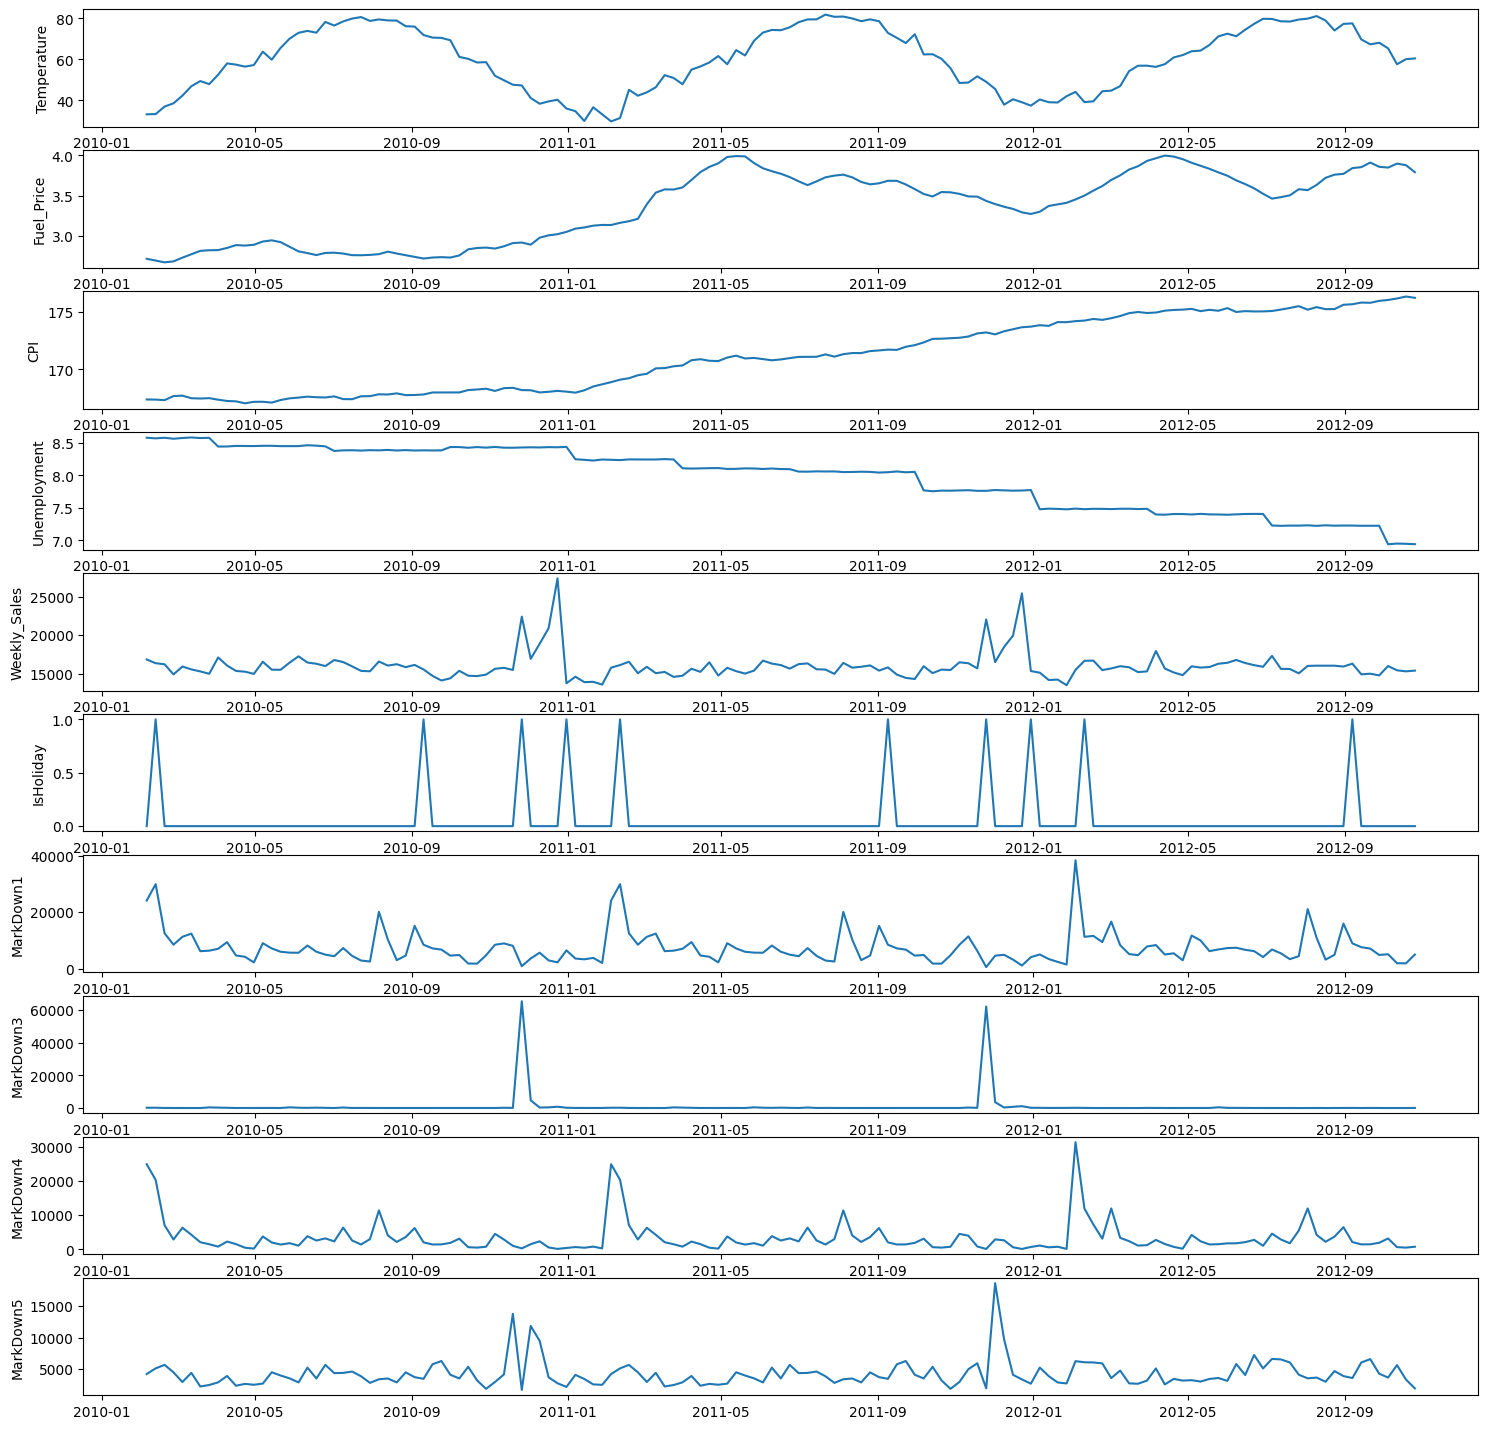

In [33]:
# Plotting all features
fig = plt.figure(figsize = (18, 18))
count_columns_ex_date = len(df_date.columns[1:])
for idx, col in enumerate(df_date.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(df_date["Date"], df_date[col])
    plt.ylabel(col)

## Prediction Models

`Feature Engineering and Data Preperation`

In [ ]:
# Getting the specific store data 


In [34]:
df['Date']

0        2010-02-05
1        2010-02-12
2        2010-02-19
3        2010-02-26
4        2010-03-05
            ...    
421565   2012-09-28
421566   2012-10-05
421567   2012-10-12
421568   2012-10-19
421569   2012-10-26
Name: Date, Length: 421570, dtype: datetime64[ns]

In [38]:
# Splitting the data into train- and test set
split_indx = int(0.8*len(df))

train = df[:split_indx]
test = df[split_indx:]

In [43]:
# Function for creating time features 
def create_time_feature(df):
    df['dayofmonth'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
    return df

In [44]:
train = create_time_feature(train)
test = create_time_feature(test)
train.head()

C:\Users\fredr\AppData\Local\Temp\ipykernel_15848\1416085448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofmonth'] = df['Date'].dt.day
C:\Users\fredr\AppData\Local\Temp\ipykernel_15848\1416085448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['Date'].dt.dayofweek
C:\Users\fredr\AppData\Local\Temp\ipykernel_15848\1416085448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,Store,Type,Size,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,...,MarkDown5,CPI,Unemployment,dayofmonth,dayofweek,quarter,month,year,dayofyear,weekofyear
0,1,0,151315,2010-02-05,24924.50,0,42.31,2.572,24089.612333,198.031818,...,4185.380333,211.096358,8.106,5,4,1,2,2010,36,5
1,1,0,151315,2010-02-12,46039.49,1,38.51,2.548,29880.900556,197.092500,...,5089.147556,211.242170,8.106,12,4,1,2,2010,43,6
2,1,0,151315,2010-02-19,41595.55,0,39.93,2.514,12536.748111,59.385610,...,5646.276000,211.289143,8.106,19,4,1,2,2010,50,7
3,1,0,151315,2010-02-26,19403.54,0,46.63,2.561,8504.312444,25.995714,...,4458.685000,211.319643,8.106,26,4,1,2,2010,57,8
4,1,0,151315,2010-03-05,21827.90,0,46.50,2.625,11293.039000,22.353662,...,2911.005778,211.350143,8.106,5,4,1,3,2010,64,9


In [45]:
# Setting date as index 
train = train.set_index('Date')
test = test.set_index('Date')

,Store,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,dayofmonth,dayofweek,quarter,month,year,dayofyear,weekofyear
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,151315,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,5,4,1,2,2010,36,5
2010-02-12,1,0,151315,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,12,4,1,2,2010,43,6
2010-02-19,1,0,151315,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,19,4,1,2,2010,50,7
2010-02-26,1,0,151315,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,26,4,1,2,2010,57,8
2010-03-05,1,0,151315,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,5,4,1,3,2010,64,9


In [46]:
# Defining target variable and features 
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']

`Linear Regression`

In [47]:
# Initialize Linear Regression 
osl = LinearRegression()
osl.fit(X_train, y_train)

LinearRegression()

In [48]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['OSL_Predictions'] = osl.predict(X_test)

# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['OSL_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['OSL_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['OSL_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 11743.8529
Mean Absolute Error: 11743.8529
R-squared: -0.0656


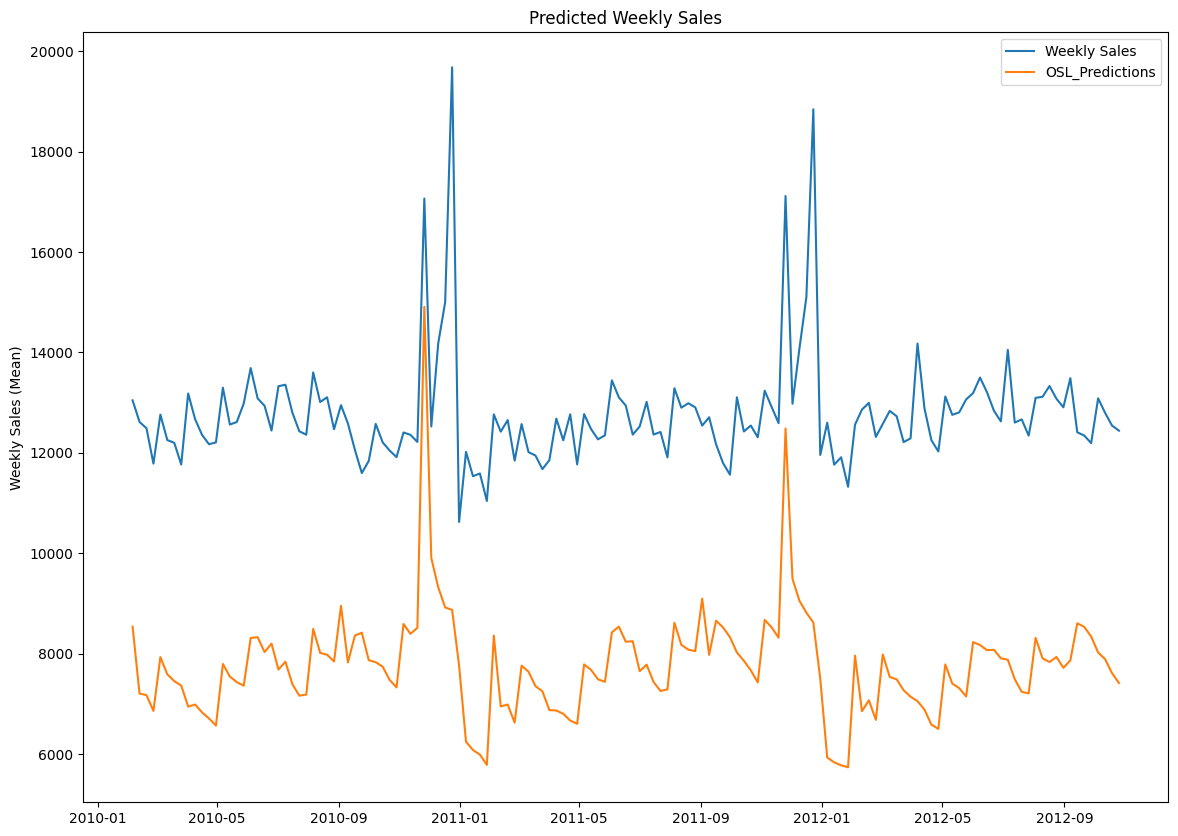

In [49]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'OSL_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['OSL_Predictions'], label='OSL_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`Random Forest Regressor`

In [51]:
# Initializing Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['RF_Predictions'] = rf.predict(X_test)

# Evaluation metrics
mse = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['RF_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

In [ ]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'OSL_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['OSL_Predictions'], label='OSL_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`XGBoost regressor`